# Recommendation System

### 1. Load the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

random_state_val = 0

In [2]:
df_train = pd.read_csv("basket_data_by_date_train.csv")
df_test = pd.read_csv("basket_data_by_date_test.csv")

print(df_train.shape)
print(df_test.shape)


(40000, 7)
(40000, 7)


In [3]:
df_train['date'] = pd.to_datetime(df_train['Date'], format='%d/%m/%Y %H:%M')
df_train['year'] = df_train.date.dt.year
df_train['month'] = df_train.date.dt.month
df_train["date_only"] = df_train.date.dt.date
df_train["week"] = (df_train["date_only"]-df_train["date_only"].min()).apply(lambda x:x.days//7)

In [4]:
df_test['date'] = pd.to_datetime(df_test['Date'], format='%d/%m/%Y %H:%M')
df_test['year'] = df_test.date.dt.year
df_test['month'] = df_test.date.dt.month


### 2.  Analyse and visualise the data

### 2.1 Check missing values and data type

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   BillNo      40000 non-null  int64         
 1   Itemname    40000 non-null  object        
 2   Quantity    40000 non-null  int64         
 3   Date        40000 non-null  object        
 4   Price       40000 non-null  float64       
 5   CustomerID  40000 non-null  int64         
 6   cost        40000 non-null  float64       
 7   date        40000 non-null  datetime64[ns]
 8   year        40000 non-null  int32         
 9   month       40000 non-null  int32         
 10  date_only   40000 non-null  object        
 11  week        40000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(4), object(3)
memory usage: 3.4+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   BillNo      10000 non-null  float64       
 1   Itemname    10000 non-null  object        
 2   Quantity    10000 non-null  float64       
 3   Date        10000 non-null  object        
 4   Price       10000 non-null  float64       
 5   CustomerID  10000 non-null  float64       
 6   cost        10000 non-null  float64       
 7   date        10000 non-null  datetime64[ns]
 8   year        10000 non-null  float64       
 9   month       10000 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 3.1+ MB


- Some data type is different between training dataset and test dataset. BillNo are used to create model. Therefore, the type of BillNo is converted into int. No modifications are necessary since other features with different data types will not be used.
- Exclude missing rows contained in test dataset.

### 2.2 Check year and month in dataset

In [7]:
df_train[["year","month"]].value_counts().reset_index()

,year,month,count
0,2010,12,18159
1,2011,1,14087
2,2011,2,7754


In [8]:
df_test[["year","month"]].value_counts().reset_index()

,year,month,count
0,2011.0,2.0,5235
1,2011.0,3.0,4765


When selecting candidate algorithms, December 2010 and January 2011 will be used as training data, and February 2011 will be used as validation data. During testing of the final model, all training data will be utilised. For the final model, all months from December to February is used as the training data. The test dataset consists of February and March 2011 data, which will be directly utilised as the test data for the final model.

### 2.3 Analyse Sales Week and Sales Frequency

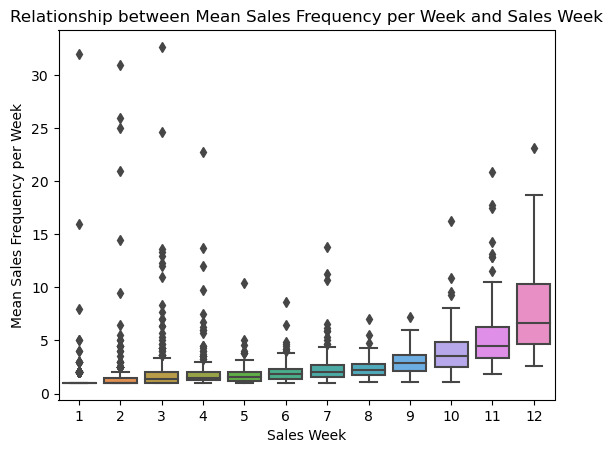

In [9]:
df_num_span_w = df_train.copy().groupby(["Itemname","week"])["date_only"].agg(["count","min"]).reset_index()
df_num_span_w.rename(columns={"min":"date"},inplace=True)
df_num_span_w.reset_index(inplace=True)

df_num_span = df_num_span_w.copy().groupby(["Itemname"]).agg({"count": "mean", "date": "count"})
df_num_span.reset_index(inplace=True)
df_num_span.rename(columns={"count":"freq","date":"weeks"},inplace=True)

sns.boxplot(x="weeks", y="freq", data=df_num_span)
# plt.title("Number of Sales per Week")
plt.title("Relationship between Mean Sales Frequency per Week and Sales Week")
plt.xlabel("Sales Week")
plt.ylabel("Mean Sales Frequency per Week")
plt.show()


The above graph shows the sales frequency and sales period (number of weeks) for each item using box plots. Items can be classified into three main categories based on the sales period and sales count:

- Short sales period with high sales count: Seasonal items
- Short sales period with low sales count: Low-selling items
- Long sales period: Long-selling items

Specifically, items  in each category are checked bellow 

In [10]:
#　Seasonal items
df_num_span[(df_num_span["weeks"]<4) & (df_num_span["freq"]>20)].head()

,Itemname,freq,weeks
1048,HAND WARMER BIRD DESIGN,25.0,2
1049,HAND WARMER OWL DESIGN,21.0,2
1051,HAND WARMER RED RETROSPOT,32.0,1
1052,HAND WARMER SCOTTY DOG DESIGN,26.0,2
1053,HAND WARMER UNION JACK,31.0,2


In [11]:
#　Low-selling items
df_num_span[(df_num_span["weeks"]<4) & (df_num_span["freq"]<5)].head()

,Itemname,freq,weeks
0,10 COLOUR SPACEBOY PEN,1.333333,3
13,12 PINK HEN+CHICKS IN BASKET,1.000000,1
16,15 PINK FLUFFY CHICKS IN BOX,2.000000,1
18,2 PICTURE BOOK EGGS EASTER BUNNY,1.333333,3
19,2 PICTURE BOOK EGGS EASTER CHICKS,1.000000,2


In [12]:
# Long-selling items
df_num_span[df_num_span["weeks"]>10].head()

,Itemname,freq,weeks
27,3 HOOK PHOTO SHELF ANTIQUE WHITE,4.272727,11
80,60 TEATIME FAIRY CAKE CASES,4.454545,11
81,72 SWEETHEART FAIRY CAKE CASES,6.636364,11
95,AIRLINE BAG VINTAGE JET SET RED,2.636364,11
97,AIRLINE BAG VINTAGE TOKYO 78,4.272727,11


When classified into three categories based on sales period and sales frequency, it is evident that items with short sales periods and high sales frequency correspond to seasonal items. Low-selling items and seasonal items are excluded from the prediction targets as it is unclear whether they are being sold at the time of model utilization. Therefore, only long-selling items are considered as prediction targets. However, it is essential to check whether low-selling items and seasonal items are included in the baskets. As a definition for long-selling items, items with sales periods exceeding 10 weeks are considered long-selling items.

### 2.4 Check Itemname

In [13]:
print(len(df_train["Itemname"].apply(lambda x: re.sub(" +"," ",x)).unique()))
print(len(df_train["Itemname"].unique()))
df_itemname_check = df_train.copy()
df_itemname_check["Itemname_rep"] = df_itemname_check["Itemname"].apply(lambda x: re.sub(" +"," ",x))
df_itemname_grp1 = df_itemname_check[["Itemname","Itemname_rep"]].value_counts().reset_index()
df_itemname_grp2 = df_itemname_check[["Itemname_rep"]].value_counts().reset_index()
df_itemname_merge = pd.merge(df_itemname_grp1, df_itemname_grp2, on=["Itemname_rep","count"], how='outer', indicator=True)
print(sorted(list(df_itemname_merge[df_itemname_merge["_merge"]!="both"]["Itemname"].dropna().unique())))

2520
2523
['BAKING MOULD TOFFEE CUP  CHOCOLATE', 'BAKING MOULD TOFFEE CUP CHOCOLATE', 'CHERRY BLOSSOM  DECORATIVE FLASK', 'CHERRY BLOSSOM DECORATIVE FLASK', 'COLUMBIAN  CUBE CANDLE', 'COLUMBIAN CUBE CANDLE']


Different Itemnames exist due to spacing differences. In cases where consecutive spaces exist, they are replaced with single spaces.

### 2.5 Summary

- Remove missing rows from df_test (according to 2.1).
- Convert BillNo in df_test to integer type (according to 2.1).
- When determining the algorithm, use December and January from df_train as training data and February as the test data. For the final model, use all months from December to February as the training data (according to 2.2).
- Consider items that have been sold for more than 10 weeks as prediction targets (according to 2.3).
- Replace consecutive spaces in Itemname with single spaces (according to 2.4).

### 3. Pre-process the data

### 3.1 Clean data

In [14]:
df_train_prep = df_train.copy()

# Replace consecutive spaces in Itemname with a single space
df_train_prep["Itemname"] = df_train_prep.copy()["Itemname"].apply(lambda x: re.sub(" +"," ",x))

# Narrow down to the columns to be used
df_train_prep = df_train_prep.groupby(["BillNo","Itemname"])["month"].max().reset_index()

In [15]:
# Exclude missing rows
df_test_prep = df_test.copy().dropna()

# Replace consecutive spaces in Itemname with a single space
df_test_prep["Itemname"] = df_test_prep.copy()["Itemname"].apply(lambda x: re.sub(" +"," ",x))

# Narrow down to the columns to be used
df_test_prep = df_test_prep[["BillNo","Itemname"]].drop_duplicates()

# Change data type of BillNo
df_test_prep["BillNo"] = df_test_prep["BillNo"].astype(int)

### 3.2 Set up the prediction target

In [16]:
# Predict items that have been on sale for more than 10 weeks.
border_weeks = 10
long_selling_items = df_num_span[df_num_span["weeks"]>border_weeks].reset_index()["Itemname"].unique()

In [17]:
len(long_selling_items)

214

### 3.3 Create a dataset for candidate model selection

|                 | Dataset for Training | Dataset for Evaluation |
|-----------------|----------------------|------------------------|
| Candidate Models| Dec 2010 to Jan 2011 | Feb 2011               |
| Final Model     | Dec 2010 to Feb 2011 | Feb 2011 to Mar 2011  |

In [18]:
# The dataset for experiments
df_ex_train = df_train_prep.copy()[df_train_prep["month"]!=2]
df_ex_valid = df_train_prep.copy()[df_train_prep["month"]==2]
print(df_ex_train.shape)
print(df_ex_valid.shape)

# The dataset for final model
df_fi_train = df_train_prep.copy()
df_fi_test = df_test_prep.copy()

print(df_fi_train.shape)
print(df_fi_test.shape)

(31019, 3)
(7546, 3)
(38565, 3)
(9686, 2)


In [19]:
# Exclude Itemnames that exist only in the validation and test datasets.
df_ex_valid = df_ex_valid.copy()[df_ex_valid["Itemname"].isin(df_ex_train["Itemname"].unique())]
df_fi_test = df_fi_test.copy()[df_fi_test["Itemname"].isin(df_fi_train["Itemname"].unique())]

In [20]:
# Use only baskets (BillNo) containing more than one item in either the validation and test data
# since one long-selling item is used for ground truth.

# Validation dataset
df_valid_item_cnt = df_ex_valid["BillNo"].value_counts().reset_index()

df_valid_multi_item = df_valid_item_cnt[df_valid_item_cnt["count"]>1]
df_ex_valid = df_ex_valid[df_ex_valid["BillNo"].isin(df_valid_multi_item["BillNo"].to_list())]
df_ex_valid.shape

billno_long_sellings = df_ex_valid[df_ex_valid["Itemname"].isin(long_selling_items)]["BillNo"].unique()
df_ex_valid = df_ex_valid[df_ex_valid["BillNo"].isin(billno_long_sellings)]

# Test dataset
df_test_item_cnt = df_fi_test["BillNo"].value_counts().reset_index()

df_test_multi_item = df_test_item_cnt[df_test_item_cnt["count"]>1]
df_fi_test = df_fi_test[df_fi_test["BillNo"].isin(df_test_multi_item["BillNo"].to_list())]

billno_long_sellings = df_fi_test[df_fi_test["Itemname"].isin(long_selling_items)]["BillNo"].unique()
df_fi_test = df_fi_test[df_fi_test["BillNo"].isin(billno_long_sellings)]

In [21]:
# One long-selling item in each basket (BillNo) of validation and test dataset is treated as ground truth.

# Validation dataset
print(df_ex_valid.shape)
df_valid_answer = pd.DataFrame()
for valid_bill in df_ex_valid["BillNo"].unique():
    df_tmp = df_ex_valid[(df_ex_valid["BillNo"]==valid_bill) & (df_ex_valid["Itemname"].isin(long_selling_items))].sample(random_state=random_state_val)
    df_valid_answer = pd.concat([df_valid_answer,df_tmp])
    
df_ex_valid = df_ex_valid.drop(index=df_valid_answer.index)
print(df_ex_valid.shape)
print(df_valid_answer.shape)

# Test dataset
print(df_fi_test.shape)
df_test_answer = pd.DataFrame()
for test_bill in df_fi_test["BillNo"].unique():
    df_tmp = df_fi_test[(df_fi_test["BillNo"]==test_bill) & (df_fi_test["Itemname"].isin(long_selling_items))].sample(random_state=random_state_val)
    df_test_answer = pd.concat([df_test_answer,df_tmp])
    
df_fi_test = df_fi_test.drop(index=df_test_answer.index)
print(df_fi_test.shape)
print(df_test_answer.shape)


(7234, 3)
(6779, 3)
(455, 3)
(9133, 2)
(8635, 2)
(498, 2)


In collaborative filtering, the rating in this project can be based on Quantity or whether a purchase was made (binary values). For this project, binary values is chosen since there are two reasons.

- Reason 1:   
If "Quantity" is chosen, the recommendation score become expected value of the quantity to purchase, which is derived from the rating and similarity score. On the other hand, if binary values is chosen, the recommendation score represents the expected probability of making a purchase. Since it is crucial whether the user will purchase the recommendation, a recommendation score indicating the probability of purchase is desirable.

- Reason 2:   
When calculating the similarity score (cosine similarity), "Quantity" results in items with larger quantities having a stronger influence on the similarity score than items with small amount. For instance, if the similarity score is computed using a multiple cheap items (e.g., 10 apples) and one expensive item (e.g., 1 desk), "Quantity" would lead to the inexpensive items having a greater impact on the similarity score compared to the expensive item. To prevent the influence such as this case, binary values is selected for rating.


In [22]:
# Create a matrix with BillNo on the vertical axis and Itemname on the horizontal axis bellow
df_ex_train_basket = pd.crosstab(df_ex_train["BillNo"],df_ex_train["Itemname"]).reset_index()

df_ex_basket_valid = pd.DataFrame(columns=df_ex_train_basket.columns)
df_ex_basket_valid_val = pd.crosstab(df_ex_valid["BillNo"],df_ex_valid["Itemname"]).reset_index()
df_ex_basket_valid = pd.concat([df_ex_basket_valid,df_ex_basket_valid_val]).fillna(0)


df_fi_train_basket = pd.crosstab(df_fi_train["BillNo"],df_fi_train["Itemname"]).reset_index()

df_fi_basket_test = pd.DataFrame(columns=df_fi_train_basket.columns)
df_fi_basket_test_val = pd.crosstab(df_fi_test["BillNo"],df_fi_test["Itemname"]).reset_index()
df_fi_basket_test = pd.concat([df_fi_basket_test,df_fi_basket_test_val]).fillna(0)

print(df_ex_train_basket.shape)
print(df_ex_basket_valid.shape)
print(df_fi_train_basket.shape)
print(df_fi_basket_test.shape)

(1998, 2416)
(455, 2416)
(2524, 2521)
(498, 2521)


### 4. Implement, train and test prediction models

Model-based Collaborative Filtering models are implemented below. The evaluation metrics of the models include the Accuracy, which indicates the proportion of instances where the ground truth matches the top recommendation in the recommendation list, Rank and Rank Rate, which represent the position of items in the recommendation list. Rank Rate tends towards 0 for higher recommendation scores and towards 1 for lower scores. Futhermore, the mean reciprocal rank (MRR), which is a common metric for Collaborative Filtering, is also checked (Hasan  & Roy 2019, p. 13). 

### 4.1. Define class and function for building coreference filtering model and evaluation

The class for collaborative filtering is defined below. In this project, a CF model that predicts items to be put in the basket by customers is built. Therefore, user-based collaborative filtering is utilised. Item-based collaborative filtering predicts similar items from the basket (Singh et al. 2021, p. 857), which is not suitable for our task, so we will not use it in this project.

In [23]:
# Coreference Filtering model
class CollaborativeFiltering:
    def __init__(self, norm_flg=True):
        self.norm_flg = norm_flg
        
    def fit(self, source_data, long_selling_items):
        self.user_ratings = source_data.drop(columns="BillNo").to_numpy()
        self.items = pd.DataFrame(source_data.drop(columns="BillNo").T.reset_index().loc[:,"Itemname"])
        self.long_selling_index = list(self.items[self.items["Itemname"].isin(long_selling_items)].index)
        
    def predict(self, target_data):
        
        target_rating = target_data.drop(columns="BillNo").to_numpy()[0]
        recommend_indices, predicted_ratings = self.recommend_items(target_rating)
        recommend_long_selling = recommend_indices[np.isin(recommend_indices,self.long_selling_index)]

        pred_long_selling = predicted_ratings[np.isin(recommend_indices,self.long_selling_index)]
        df_pred = self.items.loc[recommend_long_selling,"Itemname"].reset_index()
        df_pred["purchase_rate"] = pred_long_selling
        df_pred.drop(columns="index",inplace=True)
        
        return df_pred
        
    def similarity(self, user1, user2):
    
        if self.norm_flg:
            user1_z = self.zscore(user1)
            user2_z = self.zscore(user2)

            dot_product = np.dot(user1_z, user2_z)

            magnitude_user1 = np.linalg.norm(user1_z)
            magnitude_user2 = np.linalg.norm(user2_z)
        else:
            dot_product = np.dot(user1, user2)

            magnitude_user1 = np.linalg.norm(user1)
            magnitude_user2 = np.linalg.norm(user2)

        similarity = dot_product / (magnitude_user1 * magnitude_user2)
    
        return similarity

    def zscore(self, x, axis = None):
        xmean = np.mean(x)
        xstd  = np.std(x)
        zscore = (x-xmean)/xstd
        return zscore
    
    def predict_prob(self, purchase_flg, target_rating, similarities):

        if len(similarities)==0:
            weighted_purchase_prob=0
        else:
            weighted_purchase_prob = np.sum(purchase_flg * similarities) / np.sum(similarities)

        return weighted_purchase_prob

    def recommend_items(self, target_rating):

        similarities = np.array([self.similarity(target_rating, user) for user in self.user_ratings])
        similarities = np.where(similarities<0,0,similarities)
        predicted_ratings = [0 if target_rating[item_index] == 1 else self.predict_prob(self.user_ratings[:, item_index], target_rating, similarities) for item_index in range(len(target_rating))]

        sorted_indices = np.argsort(predicted_ratings)[::-1]
        sorted_predicted_ratings = np.sort(predicted_ratings)[::-1]
        return sorted_indices, sorted_predicted_ratings
    
    def ana_similarities(self, target_data):
        target_rating = target_data.drop(columns="BillNo").to_numpy()[0]
        similarities = np.array([self.similarity(target_rating, user) for user in self.user_ratings])
        similarities = np.where(similarities<0,0,similarities)
        
        return similarities
    
    

In [24]:
def calc_rank(df_answer, df_rank, target_bill):
    answer_item = df_answer[df_answer["BillNo"]==target_bill]["Itemname"].values[0]
    index_val = df_rank[df_rank["Itemname"]==answer_item].index[0]
    rank_val = index_val+1
    
    return rank_val


In [25]:
# Mean Reciprocal Rank
def mrr(rank_list):
    reciprocal_ranks = [1 / rank for rank in rank_list]
    return sum(reciprocal_ranks) / len(reciprocal_ranks)

def accuracy(rank_list):
    return sum([1 for i in rank_list if i==1])/len(rank_list)

def mean_rank(rank_list):
    return np.mean(rank_list)

def mean_rank_rate(rank_list):
    return np.mean(rank_list)/len(long_selling_items)

def median_rank(rank_list):
    return np.median(rank_list)

def median_rank_rate(rank_list):
    return np.median(rank_list)/len(long_selling_items)

def show_metrics(rank_list):
    
    mrr_score = mrr(rank_list)
    acc = accuracy(rank_list)
    m_rank = mean_rank(rank_list)
    m_rank_pct = mean_rank_rate (rank_list)
    md_rank = median_rank (rank_list)
    md_rank_pct = median_rank_rate(rank_list)
    
    return pd.DataFrame({"mrr":[mrr_score],
                         "accuracy":[acc],
                         "mean_rank":[m_rank],
                         "mean_rank_rate":[m_rank_pct],
                         "median_rank":[md_rank],
                         "median_rank_rate":[md_rank_pct]
                        })

In [26]:
def show_rank_hist(df):
    df["rank_rate"] = df["rank"]/len(long_selling_items)
    plt.figure(figsize=(6,2))
    plt.hist(df["rank"],bins=20,rwidth=0.8)
    plt.axvline(x=df["rank"].mean(),color='r',label="Mean Rank")
    plt.axvline(x=df["rank"].median(),color='g',label="Median Rank")
    plt.xlim(0, len(long_selling_items))
    plt.title("Histgram of Rank")
    plt.legend()
    plt.show()


    plt.figure(figsize=(6,2))
    plt.hist(df["rank_rate"],bins=20,rwidth=0.8)
    plt.axvline(x=df["rank_rate"].mean(),color='r',label="Mean Rank Rate")
    plt.axvline(x=df["rank_rate"].median(),color='g',label="Median Rank Rate")
    plt.xlim(0, 1)
    plt.title("Histgram of Rank Rate")
    plt.legend()
    plt.show()

### 4.2. Create and evaluate candidate models

In [27]:
cf_valid = CollaborativeFiltering(norm_flg=False)
cf_valid.fit(df_ex_train_basket,long_selling_items)


rank_list=[]
num_item_list=[]

for target_bill in df_ex_basket_valid["BillNo"]:

    df_rank = cf_valid.predict(df_ex_basket_valid[df_ex_basket_valid["BillNo"]==target_bill])
    
    # Rank within the sorted ranking based on purchase probability (recommendation score)
    rank_list.append(calc_rank(df_valid_answer, df_rank, target_bill))
    
    # number of items in a basket
    num_item_list.append(len(df_ex_valid[df_ex_valid["BillNo"]==target_bill])) 
    
df_result_norm_false = pd.DataFrame({
    "rank":rank_list,
    "num_items":num_item_list
})

In [28]:
cf_valid_norm = CollaborativeFiltering(norm_flg=True)
cf_valid_norm.fit(df_ex_train_basket,long_selling_items)


rank_list=[]
num_item_list=[]

for target_bill in df_ex_basket_valid["BillNo"]:

    df_rank = cf_valid_norm.predict(df_ex_basket_valid[df_ex_basket_valid["BillNo"]==target_bill])
    
    # Rank within the sorted ranking based on purchase probability (recommendation score)
    rank_list.append(calc_rank(df_valid_answer, df_rank, target_bill))
    
    # number of items in a basket
    num_item_list.append(len(df_ex_valid[df_ex_valid["BillNo"]==target_bill])) 
    
df_result_norm_true = pd.DataFrame({
    "rank":rank_list,
    "num_items":num_item_list
})

In [29]:
show_metrics(df_result_norm_false["rank"].to_list())

,mrr,accuracy,mean_rank,mean_rank_rate,median_rank,median_rank_rate
0,0.220783,0.116484,40.250549,0.188087,17.0,0.079439


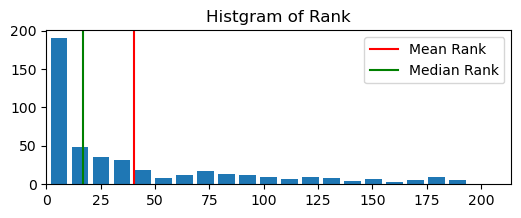

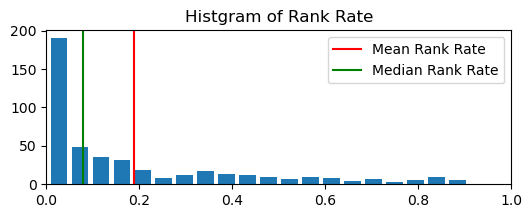

In [30]:
show_rank_hist(df_result_norm_false)

In [31]:
show_metrics(df_result_norm_true["rank"].to_list())

,mrr,accuracy,mean_rank,mean_rank_rate,median_rank,median_rank_rate
0,0.226403,0.120879,39.615385,0.185119,17.0,0.079439


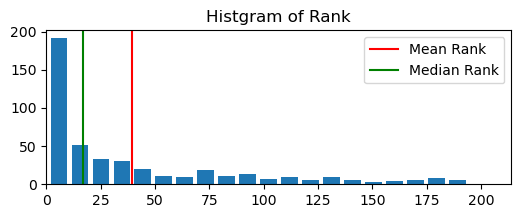

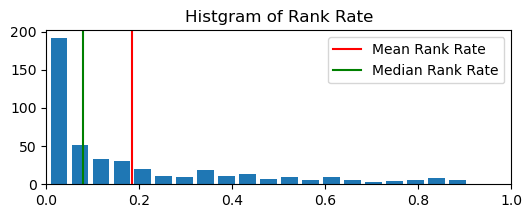

In [32]:
show_rank_hist(df_result_norm_true)

While there are no significant differences in rank-related metrics such as Median Rank Rate or Mean Rank Rate, the EM score is slightly better when normalisation is applied. Therefore, normalisation is used for the final model.

### 4.3. Create and evaluate the final models

In [33]:
cf_final = CollaborativeFiltering(norm_flg=True)
cf_final.fit(df_fi_train_basket,long_selling_items)

billno_list=[]
rank_list=[]
num_item_list=[]

for target_bill in df_fi_basket_test["BillNo"]:

    df_rank = cf_final.predict(df_fi_basket_test[df_fi_basket_test["BillNo"]==target_bill])
    
    billno_list.append(target_bill)
    
    # Rank within the sorted ranking based on purchase probability (recommendation score)
    rank_list.append(calc_rank(df_test_answer, df_rank, target_bill))
    
    # number of items in a basket
    num_item_list.append(len(df_fi_test[df_fi_test["BillNo"]==target_bill])) 
    
df_result_final = pd.DataFrame({
    "BillNo":billno_list,
    "rank":rank_list,
    "num_items":num_item_list
})

In [34]:
show_metrics(df_result_final["rank"].to_list())

,mrr,accuracy,mean_rank,mean_rank_rate,median_rank,median_rank_rate
0,0.216015,0.126506,39.899598,0.186447,19.0,0.088785


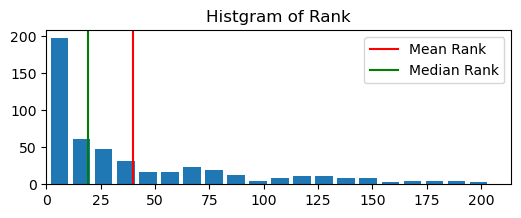

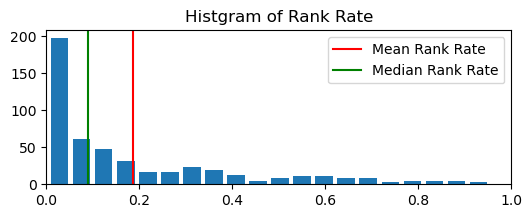

In [35]:
show_rank_hist(df_result_final)

### 4.4 Check specific examples

Comparing five samples where user bought reccomendation with five samples where user bought lower reccomendation

In [36]:
# examples where user bought top item (more than 1/214) in the recommendation list
num_sim_users=20

billno_list=[]
prob_sim_answer_list = []

df_good_sample = df_result_final[df_result_final["rank"]==1].sample(5,random_state=random_state_val)
df_good_example = pd.DataFrame(columns=["BillNo","top_similarity","probability_similar_user_buy_answer_item","answer_item"])

for target_bill in df_good_sample["BillNo"]:


    answer_item = df_test_answer[df_test_answer["BillNo"]==target_bill]["Itemname"].values[0]

    sim = cf_final.ana_similarities(df_fi_basket_test[df_fi_basket_test["BillNo"]==target_bill])
    df_sim = pd.DataFrame(sim)
    similar_billno = df_fi_train_basket.loc[df_sim[0].nlargest(num_sim_users).index]["BillNo"].to_list()
    df_sim_users = df_fi_train[df_fi_train["BillNo"].isin(similar_billno)]
    top_similarity_list = df_sim[0].nlargest(num_sim_users).to_list()

    prob_sim_answer = len(df_sim_users[df_sim_users["Itemname"]==answer_item])/len(similar_billno)

    df_good_example_tmp = pd.DataFrame({
        "BillNo":[target_bill]*len(top_similarity_list),
        "top_similarity":top_similarity_list,
        "probability_similar_user_buy_answer_item":[prob_sim_answer]*len(top_similarity_list),
        "answer_item":[answer_item]*len(top_similarity_list)
    })
    df_good_example = pd.concat([df_good_example, df_good_example_tmp])

,BillNo,answer_item,probability_similar_user_buy_answer_item,top_similarity
0,545082,SET OF 3 CAKE TINS PANTRY DESIGN,0.15,0.164941
1,545526,REGENCY CAKESTAND 3 TIER,0.45,0.284655
2,545705,ALARM CLOCK BAKELIKE GREEN,0.10,0.255938
3,545709,ROUND SNACK BOXES SET OF4 WOODLAND,0.25,0.234437
4,546031,ALARM CLOCK BAKELIKE GREEN,0.15,0.262328


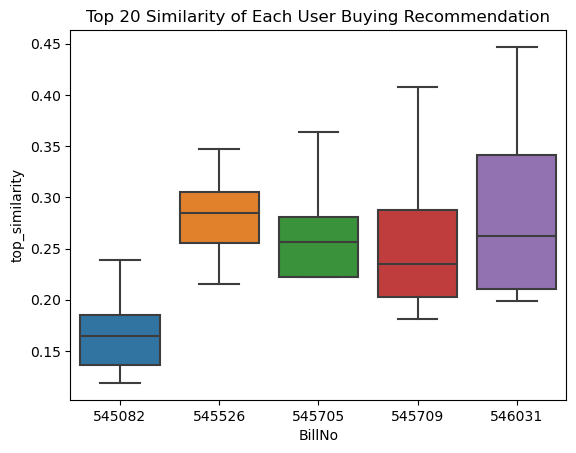

In [37]:
display(df_good_example.groupby(["BillNo",
                                 "answer_item",
                                 "probability_similar_user_buy_answer_item"])["top_similarity"]
        .median().reset_index())

sns.boxplot(x="BillNo", y="top_similarity", data=df_good_example)
plt.title("Top 20 Similarity of Each User Buying Recommendation")
plt.show()

In [38]:
# examples where user bought lower items (more than 100/214) in the recommendation list
num_sim_users=20

billno_list=[]
prob_sim_answer_list = []

df_bad_sample = df_result_final[df_result_final["rank"]>100].sample(5,random_state=random_state_val)
df_bad_example = pd.DataFrame(columns=["BillNo","top_similarity","probability_similar_user_buy_answer_item","answer_item"])

# for i,target_bill in enumerate(df_bad_sample["BillNo"]):
for target_bill in df_bad_sample["BillNo"]:


    answer_item = df_test_answer[df_test_answer["BillNo"]==target_bill]["Itemname"].values[0]

    sim = cf_final.ana_similarities(df_fi_basket_test[df_fi_basket_test["BillNo"]==target_bill])
    df_sim = pd.DataFrame(sim)
    similar_billno = df_fi_train_basket.loc[df_sim[0].nlargest(num_sim_users).index]["BillNo"].to_list()
    df_sim_users = df_fi_train[df_fi_train["BillNo"].isin(similar_billno)]
    top_similarity_list = df_sim[0].nlargest(num_sim_users).to_list()

    prob_sim_answer = len(df_sim_users[df_sim_users["Itemname"]==answer_item])/len(similar_billno)

    df_bad_example_tmp = pd.DataFrame({
        "BillNo":[target_bill]*len(top_similarity_list),
        "top_similarity":top_similarity_list,
        "probability_similar_user_buy_answer_item":[prob_sim_answer]*len(top_similarity_list),
        "answer_item":[answer_item]*len(top_similarity_list)
    })
    df_bad_example = pd.concat([df_bad_example, df_bad_example_tmp])

,BillNo,answer_item,probability_similar_user_buy_answer_item,top_similarity
0,544912,PAPER BUNTING WHITE LACE,0.00,0.207602
1,545004,HOME SWEET HOME METAL SIGN,0.00,0.240573
2,545052,METAL SIGN TAKE IT OR LEAVE IT,0.00,0.287757
3,545083,WOODEN UNION JACK BUNTING,0.00,0.332539
4,545533,SET 10 LIGHTS NIGHT OWL,0.05,0.207880


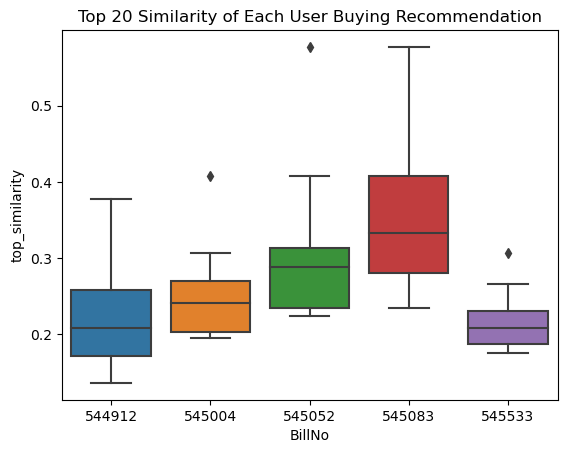

In [39]:
display(df_bad_example.groupby(["BillNo",
                                "answer_item",
                                "probability_similar_user_buy_answer_item"])["top_similarity"]
        .median().reset_index())

sns.boxplot(x="BillNo", y="top_similarity", data=df_bad_example)
plt.title("Top 20 Similarity of Each User Buying Recommendation")
plt.show()

Compared to example where user bought recommendation or not, The case where users purchased significantly different items show outliers in similarity scores. However, the actual values themselves do not differ significantly. Additionally, according to "probability_similar_user_buy_answer_item" in the both of the example tables, it can be observed that the target user purchased items that similar users did not purchase, making predictions difficult.

The presence of outliers in similarity scores can be attributed to users who tend to have fewer items in their baskets, as well as the existence of users with extremely high similarity scores. This matter will be confirmed in section 4.5.


In [40]:
# Display the top 5 items with the highest frequency in the training dataset.
df_train_prep["Itemname"].value_counts().reset_index().head(5)

,Itemname,count
0,WHITE HANGING HEART T-LIGHT HOLDER,266
1,SET OF 3 CAKE TINS PANTRY DESIGN,228
2,REGENCY CAKESTAND 3 TIER,222
3,HEART OF WICKER LARGE,193
4,REX CASH+CARRY JUMBO SHOPPER,175


The above table displays the top 5 items with the highest purchase frequency in the training data. Some items in top 5 items are included in examples where user bought recommendation. Since these items have a high purchase frequency, they are  easier to predict than low frequency items.

### 4.5. Analyse factors leading to significant deviations from predictions

In [41]:
billno_list=[]
mean_similarity_list = []
prob_sim_answer_list = []

num_sim_users = 20

for target_bill in df_fi_basket_test["BillNo"]:

    answer_item = df_test_answer[df_test_answer["BillNo"]==target_bill]["Itemname"].values[0]

    sim = cf_final.ana_similarities(df_fi_basket_test[df_fi_basket_test["BillNo"]==target_bill])
    df_sim = pd.DataFrame(sim)
    similar_billno = df_fi_train_basket.loc[df_sim[0].nlargest(num_sim_users).index]["BillNo"].to_list()
    df_sim_users = df_fi_train[df_fi_train["BillNo"].isin(similar_billno)]

    billno_list.append(target_bill)
    
    mean_top_similarity = np.mean(df_sim[0].nlargest(num_sim_users))
    mean_similarity_list.append(mean_top_similarity)

    # probability of simlar user who have answer item in their basket
    prob_sim_answer = len(df_sim_users[df_sim_users["Itemname"]==answer_item])/len(similar_billno)
    prob_sim_answer_list.append(prob_sim_answer)
    

df_result_final_ana = pd.DataFrame({
    "BillNo":billno_list,
    "mean_top_similarity":mean_similarity_list,
    "prob_sim_answer":prob_sim_answer_list
})

In [42]:
df_result_final["rank_rate"] = df_result_final["rank"]/len(long_selling_items)
df_result_final_ana = df_result_final_ana.merge(df_result_final,how="inner",on="BillNo")

df_ana_mean_sim = df_result_final_ana.groupby(["rank_rate"])["mean_top_similarity"].agg(["count","mean"])
df_ana_answer_prob = df_result_final_ana.groupby(["rank_rate"])["prob_sim_answer"].agg(["count","mean"])

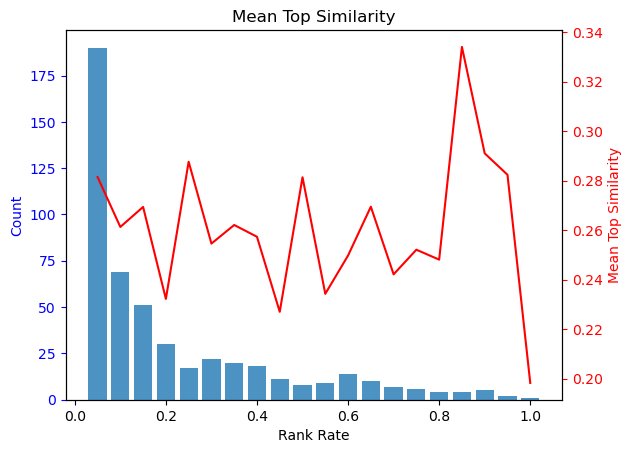

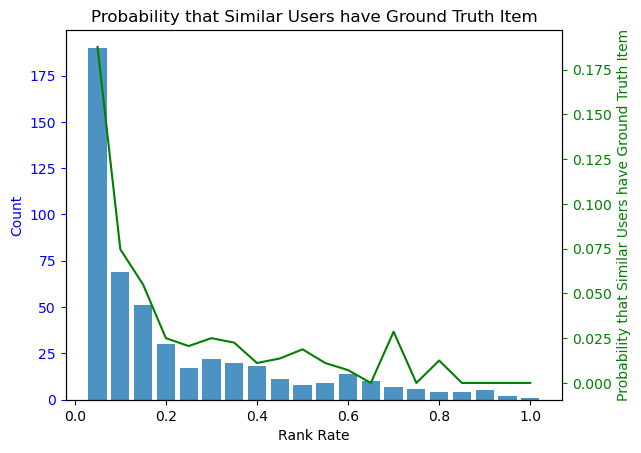

In [43]:
def summary_ana_rank(df, step):
    df["rank_rate_bin"] = pd.cut(df["rank_rate"], bins=np.arange(0,1+step,step))
    return_df = df.groupby("rank_rate_bin")["mean_top_similarity"].agg(["count","mean"])
    return_df.rename(columns={"mean":"mean_top_similarity"},inplace=True)
    return_df = return_df.merge(df.groupby("rank_rate_bin")["prob_sim_answer"].mean(),how="inner",on="rank_rate_bin")
    return_df = return_df.reset_index()
    return_df["rank_rate_bin"] = return_df["rank_rate_bin"].apply(lambda x: clean_cut(x)).astype(float)
    return return_df

def clean_cut(x):
    return re.split(",",str(x))[1].replace(")","").replace("]","").replace(" ","")

def show_summary_rank_graph(df, target_variable, title_name, y_label, color, width=0.04):
    fig, ax1 = plt.subplots()
    ax1.bar(df["rank_rate_bin"], df["count"], alpha=0.8, width=width , label="Count")
    ax1.set_xlabel("Rank Rate")
    ax1.set_ylabel("Count", color="b")
    ax1.tick_params("y", colors="b")

    ax2 = ax1.twinx()
    ax2.plot(df["rank_rate_bin"], df[target_variable], color=color, label="Mean")
    ax2.set_ylabel(y_label, color=color)
    ax2.tick_params("y", colors=color)

    plt.title(title_name)
    plt.show()

df_summary_rank = summary_ana_rank(df_result_final_ana,0.05)
show_summary_rank_graph(df_summary_rank, "mean_top_similarity", "Mean Top Similarity", "Mean Top Similarity", "r")
show_summary_rank_graph(df_summary_rank, "prob_sim_answer", "Probability that Similar Users have Ground Truth Item", "Probability that Similar Users have Ground Truth Item", "g")

The first graph shows the mean of the top 20 similarity scores for each Rank Rate band, while the second graph displays the proportion where top 20 similar users purchase the item among each Rank Rate band.

The first graph indicates that the similarity score remains high even as the Rank Rate increases. On the other hand, the second graph that the proportion of similar users who purchase the answer item decreases as the Rank Rate increases. As well as the above specific examples in section 4.4, it can be confirmed statistically that similar users with higher Rank Rates tend not to purchase the ground truth item. Therefore, it is difficult to recommend ground truth item to target user when items in a basket is few. 

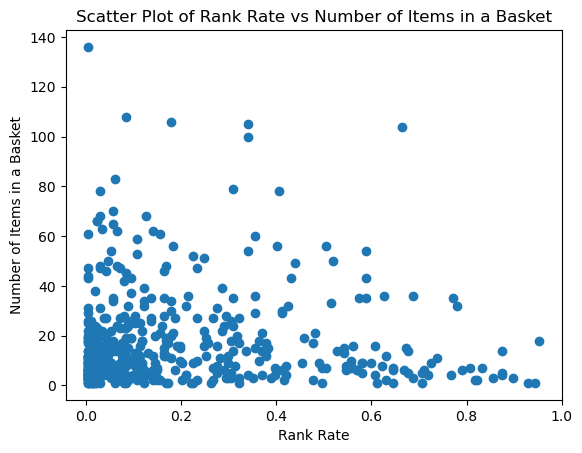

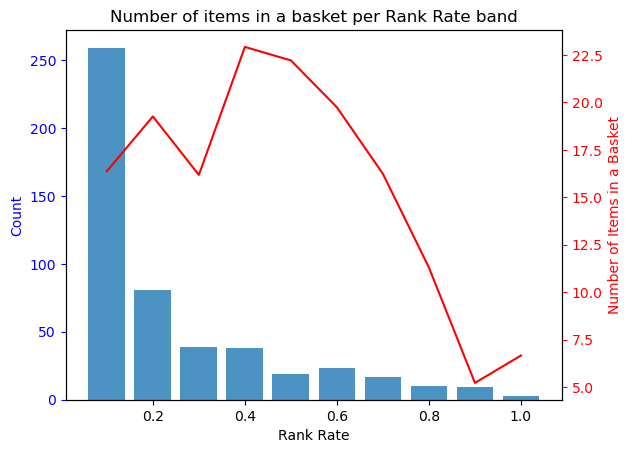

In [44]:
plt.scatter(df_result_final["rank_rate"], df_result_final["num_items"])
plt.ylabel("Number of Items in a Basket")
plt.xlabel("Rank Rate")
plt.title("Scatter Plot of Rank Rate vs Number of Items in a Basket")

step=0.1
df_num_items_per_rank = df_result_final.copy()
df_num_items_per_rank["rank_rate_bin"] = pd.cut(df_num_items_per_rank["rank_rate"], bins=np.arange(0,1+step,step))
df_num_items_per_rank = df_num_items_per_rank.groupby("rank_rate_bin")["num_items"].agg(["count","mean"])
df_num_items_per_rank.rename(columns={"mean":"mean_num_items"},inplace=True)
df_num_items_per_rank = df_num_items_per_rank.reset_index()
df_num_items_per_rank["rank_rate_bin"] = df_num_items_per_rank["rank_rate_bin"].apply(lambda x: clean_cut(x)).astype(float)

show_summary_rank_graph(df_num_items_per_rank,"mean_num_items","Number of items in a basket per Rank Rate band", "Number of Items in a Basket", "r",0.08)

the factors contributing to missing the ground truth items were analysed based on the number of items in the basket from which predictions were made. The first graph shows a scatter plot of Rank Rate and the number of items in a basket, while The second graph aggregates the Rank Rate into bins and displays the mean number of items in a basket for each Rank Rate.

it can be observed that the number of items in the basket decreases as the Rank Rate increases. With fewer items in a basket, there might be less information available for prediction, leading to lower accuracy.

### 4.6. Summary of the final model

While the EM score of 12.7% is not high, the model demonstrates a certain level of accuracy. Two tendencies for missing ground truth are observed:

- When similar users to the target user do not purchase the predicted items.
- When the basket contains few items.

The former could potentially improve with a larger dataset, while the latter could see improved accuracy by recommending to customers whose baskets already contain certain items.

## B. References

Hasan, M & Roy, F 2019, ‘An item–item collaborative filtering recommender system using trust and genre to address the cold-start problem’, <i>Big Data and Cognitive Computing</i>, vol. 3, article no: 3.

Singh, PK, Ahmed, R, Rajput, IS & Choudhury, P 2021, ‘A comparative study on prediction approaches of item-based collaborative filtering in neighborhood-based recommendations’, <i>Wireless Personal Communications</i>, vol. 121, no. 1, pp. 857–877.